## Bearing failure Anomaly Detection

목차(Context)
- 문제상황 및 데이터 살펴보기
- 문제해결 프로세스 정의
- Data 전처리 및 EDA
- 시계열 데이터 특성 추출
- 이상 탐지 모델링

# 1. 문제상황 및 데이터 살펴보기

### 시나리오
A사는 냉장고를 생산하는 업체이다. 냉장고 제작 공정은 컨베이어 벨트 방식으로 제작이 되며, 하나의 공정이 중단될 시 모든 공정이 All Stop 되는 특성을 가진다.
냉장고를 제작하는데 있어 주요 공정인 A 설비는 Bearing 을 핵심 부품으로 사용한다. Bearing 은 사용할 수록 마모가 되어 주기적으로 변경을 해줘야하는 부품 특성을 갖고 있다. A사는 Bearing이 파손되기 이전에 이상점을 감지하여 사전 유지보수를 통해 All Stop을 사전에 방지하고자 한다.

## (1) 데이터 살펴보기

- Bearing Sensor Data
- 데이터 명세
|Column|Description|
|:---|:---|
|index|측정 시간 Index|
|Bearing 1|베어링 1 진동 센서 값|
|Bearing 2|베어링 2 진동 센서 값|
|Bearing 3|베어링 3 진동 센서 값|
|Bearing 4|베어링 4 진동 센서 값|

In [1]:
# Warning 제거
import warnings
warnings.filterwarnings('ignore')

# Data folder read
import numpy as np
import pandas as pd

pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)

# Data read
df = pd.read_csv("Averaged_BearingTest_Dataset.csv")
df.head()

,Unnamed: 0,Bearing 1,Bearing 2,Bearing 3,Bearing 4
0,2004-02-12 10:52:39,0.060236,0.074227,0.083926,0.044443
1,2004-02-12 11:02:39,0.061455,0.073844,0.084457,0.045081
2,2004-02-12 11:12:39,0.061361,0.075609,0.082837,0.045118
3,2004-02-12 11:22:39,0.061665,0.073279,0.084879,0.044172
4,2004-02-12 11:32:39,0.061944,0.074593,0.082626,0.044659


In [2]:
# 컬럼명 변경
df.columns = ['time', 'Bearing1', 'Bearing2', 'Bearing3', 'Bearing4']
df.head()

,time,Bearing1,Bearing2,Bearing3,Bearing4
0,2004-02-12 10:52:39,0.060236,0.074227,0.083926,0.044443
1,2004-02-12 11:02:39,0.061455,0.073844,0.084457,0.045081
2,2004-02-12 11:12:39,0.061361,0.075609,0.082837,0.045118
3,2004-02-12 11:22:39,0.061665,0.073279,0.084879,0.044172
4,2004-02-12 11:32:39,0.061944,0.074593,0.082626,0.044659


# 2. 문제해결 프로세스 정의

## 문제 정의
- 냉장고 공정 주요 설비 A의 고장이 발생하면 Line All Stop 리스크
- A 설비의 핵심 부품인 Bearing 마모에 따른 설비 고장

## 기대 효과 (해결을 했을 때의 이점)
- 설비 고장을 사전에 방지하여, Line Stop을 방지
- Line Stop 으로 인한 점검 시간 및 비용 절감
- 계획 대비 생산량 달성

## 해결 방안
- Bearing Sensor Data 이상 탐지를 통해 사전고장발생 방지
    - (1) Data 전처리 및 DEA
    - (2) 시계열 데이터 특성 추출
    - (3) 이상 탐지 모델링 수행

## 성과 측정 (KPI)
- 모델 활용 전/후 Line Stop 횟수 비교
- 모델 활용 전/후 계획 대비 생산률 비교

## 현업 적용
- Bearing Sensor Data 실시간 수집 체계 구축 (스트리밍)
- Model 에 Input할 window time 결정
- Sensor Data Model Input 및 Anomaly Detection
- Anomaly Points 발견 시 유휴시간 장비 점검

## 주요 코드 미리 살펴보기
3. 데이터 전처리 및 EDA
    - pd.to_datetime(), set_index(), df.index.name=''
4. 시계열 데이터 특성 추출
    - x.year, x.month, x.day, ..., sns.boxplot(), .shift(1), rolling(window=3).mean()
5. 이상 탐지 모델링
    - StandardScaler(), PCA(), make_pipeline(scaler, pca)

# 3. 데이터 전처리 및 EDA

## Data 전처리

- 수집된 데이터의 기본 정보들을 확인

    (1) Data shape(형태) 확인
    
    (2) Data type 확인
    
    (3) Null값 확인
    
    (4) Outlier 확인 (정상범주를 벗어난 Data)

In [3]:
# Data shape 확인 (행과 열)
print('df :', df.shape)

df : (982, 5)


In [4]:
# Data Type 확인
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 982 entries, 0 to 981
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   time      982 non-null    object 
 1   Bearing1  982 non-null    float64
 2   Bearing2  982 non-null    float64
 3   Bearing3  982 non-null    float64
 4   Bearing4  982 non-null    float64
dtypes: float64(4), object(1)
memory usage: 38.5+ KB


In [5]:
# Null 값 유무 확인 (있다면 추가 처리 필요)
print(df.isnull().sum())

time        0
Bearing1    0
Bearing2    0
Bearing3    0
Bearing4    0
dtype: int64


In [6]:
# Outlier 확인 (정상 범주에서 벗어난 데이터는 사전에 처리를 해야함)
# min에서 마이너스 값이 있는지 확인
# max값이 다른 분포에 비해 많이 벗어나는지 확인
df.describe()

,Bearing1,Bearing2,Bearing3,Bearing4
count,982.000000,982.000000,982.000000,982.000000
mean,0.080951,0.078543,0.081351,0.047830
std,0.040200,0.011789,0.011607,0.009549
min,0.001168,0.000767,0.000716,0.001699
25%,0.060773,0.074240,0.076829,0.043951
50%,0.062021,0.075206,0.078187,0.044524
75%,0.083277,0.077458,0.080575,0.048130
max,0.453335,0.161016,0.151299,0.119047


In [7]:
# object 타입의 시간을 time 타입으로 변경 및 Index 설정
df['time'] = pd.to_datetime(df['time'])
df.set_index('time', inplace=True)

In [8]:
# index name 변경
df.index.name = ''

In [9]:
df.head()

,Bearing1,Bearing2,Bearing3,Bearing4
,,,,
2004-02-12 10:52:39,0.060236,0.074227,0.083926,0.044443
2004-02-12 11:02:39,0.061455,0.073844,0.084457,0.045081
2004-02-12 11:12:39,0.061361,0.075609,0.082837,0.045118
2004-02-12 11:22:39,0.061665,0.073279,0.084879,0.044172
2004-02-12 11:32:39,0.061944,0.074593,0.082626,0.044659


## Data EDA (데이터 특성 파악을 위한 초기 탐색 과정)

In [10]:
# 전체 Data 기간을 확인
df.index.min(), df.index.max()        # 7일치 데이터

(Timestamp('2004-02-12 10:52:39'), Timestamp('2004-02-19 06:22:39'))

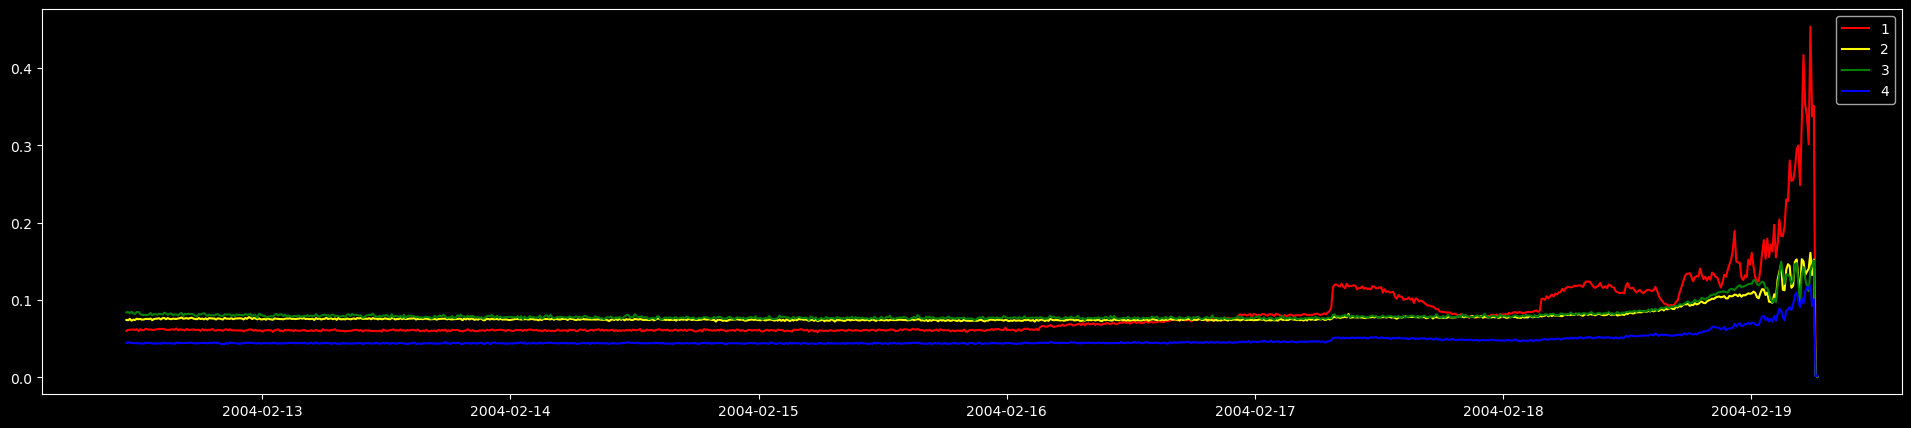

In [11]:
# 시계열 데이터 시각화로 확인
# Plotting 전체 데이터
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
plt.style.use(['dark_background'])

plt.figure(figsize=(24,5))
plt.plot(df.index, df['Bearing1'], linestyle='-', color='red', label='1');
plt.plot(df.index, df['Bearing2'], linestyle='-', color='yellow', label='2');
plt.plot(df.index, df['Bearing3'], linestyle='-', color='green', label='3');
plt.plot(df.index, df['Bearing4'], linestyle='-', color='blue', label='4');
plt.legend();

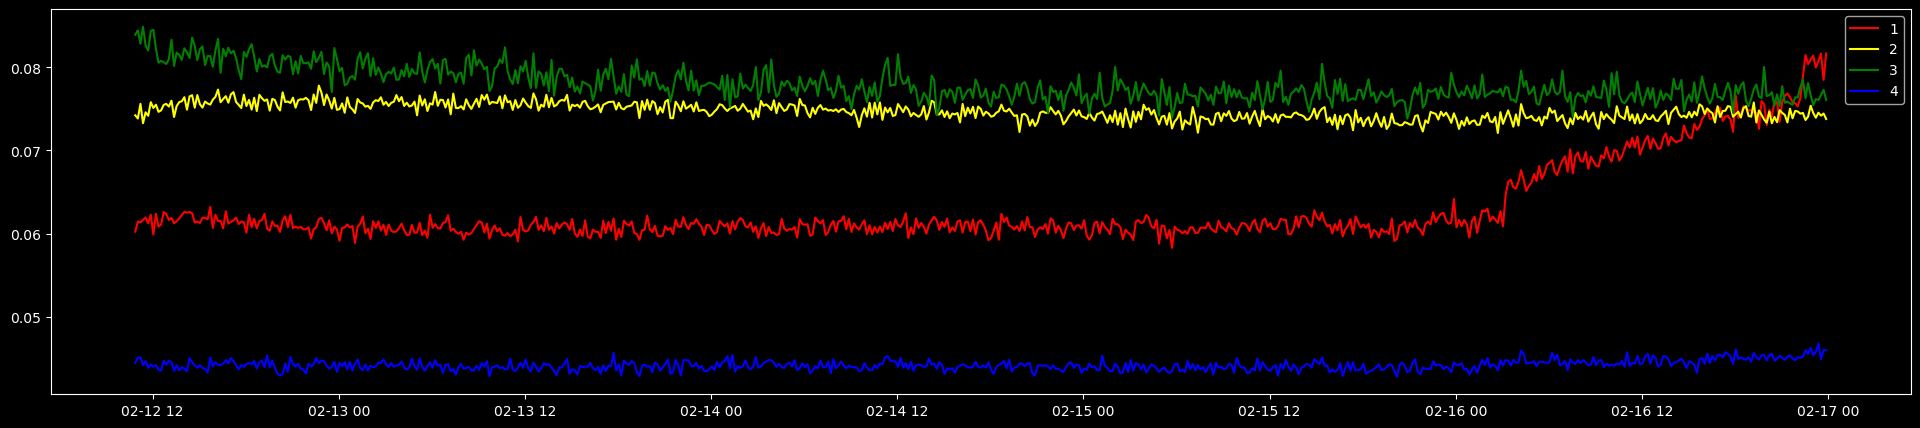

In [12]:
# Before Data 기간 확인
df_before = df[:'2004-02-17 00:00:00']

plt.figure(figsize=(24,5))
plt.plot(df_before.index, df_before['Bearing1'], linestyle='-', color='red', label='1');
plt.plot(df_before.index, df_before['Bearing2'], linestyle='-', color='yellow', label='2');
plt.plot(df_before.index, df_before['Bearing3'], linestyle='-', color='green', label='3');
plt.plot(df_before.index, df_before['Bearing4'], linestyle='-', color='blue', label='4');
plt.legend();

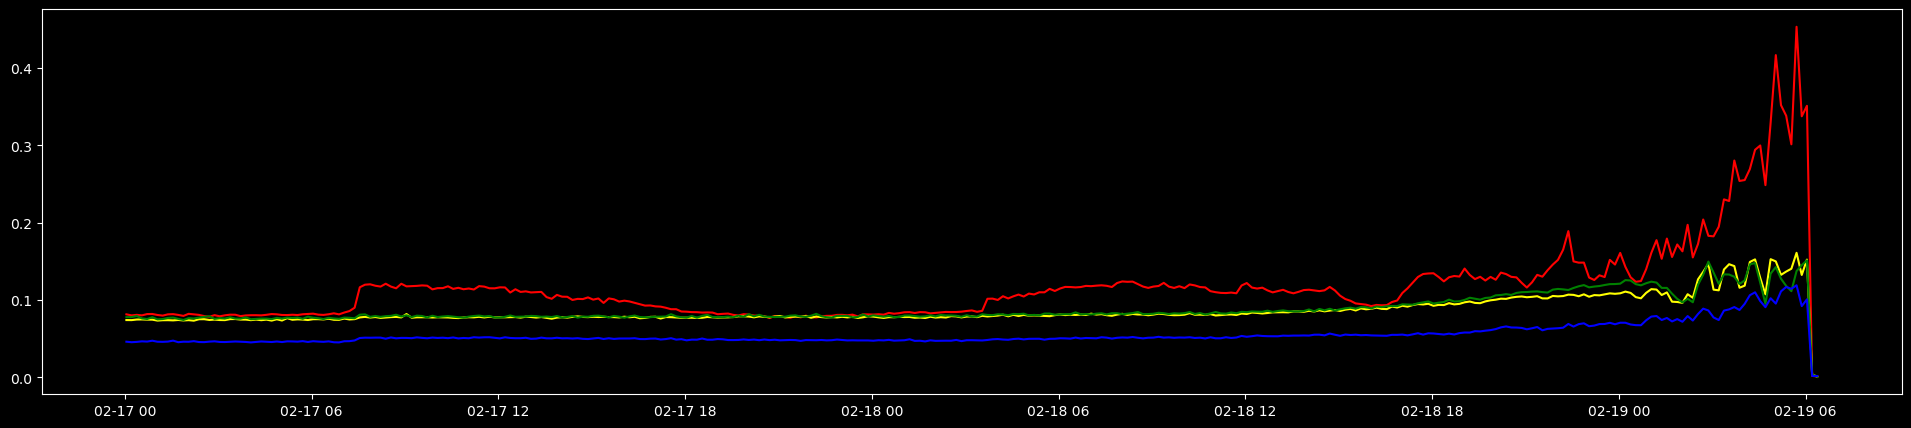

In [13]:
# After Data 기간 확인
df_after = df['2004-02-17 00:00:00':]

plt.figure(figsize=(24,5))
plt.plot(df_after.index, df_after['Bearing1'], linestyle='-', color='red', label='1');
plt.plot(df_after.index, df_after['Bearing2'], linestyle='-', color='yellow', label='2');
plt.plot(df_after.index, df_after['Bearing3'], linestyle='-', color='green', label='3');
plt.plot(df_after.index, df_after['Bearing4'], linestyle='-', color='blue', label='4');

<AxesSubplot:xlabel='Bearing1', ylabel='Density'>

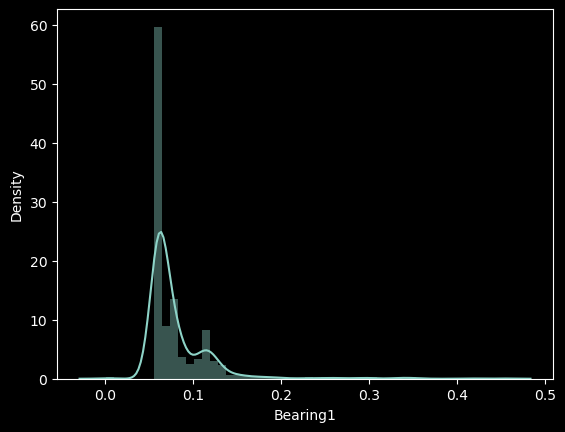

In [15]:
# 정상/비정상 구간 시각화
sns.distplot(df['Bearing1'])

EDA 작업 및 분석을 통해
각 Bearing 센서에는 서로 간 연관관계가 없다는 것을 파악하고
이상진단이 명확히 보인다는 인사이트를 얻었기에
추가적인 분석이 필요없을 것으로 보임

# 4. 시계열 데이터 특성 추출

## Data 관련 변수 추출

- 시계열 데이터는 과거의 데이터에 영향을 받는다 (지연데이터 생성)
- 트랜드 지표 (추세)
- 파생 데이터 추출

In [16]:
df.head()

,Bearing1,Bearing2,Bearing3,Bearing4
,,,,
2004-02-12 10:52:39,0.060236,0.074227,0.083926,0.044443
2004-02-12 11:02:39,0.061455,0.073844,0.084457,0.045081
2004-02-12 11:12:39,0.061361,0.075609,0.082837,0.045118
2004-02-12 11:22:39,0.061665,0.073279,0.084879,0.044172
2004-02-12 11:32:39,0.061944,0.074593,0.082626,0.044659


In [17]:
# 년, 월, 요일, 시간 추가
# [참조] x.year, x.month, x.day, x.minute, x.second, x.microsecond, x.weekday()
df['year'] = df.index.year
df['month'] = df.index.month
df['weekday'] = df.index.weekday
df['hour'] = df.index.hour
df['date'] = df.index.date
df.head()

,Bearing1,Bearing2,Bearing3,Bearing4,year,month,weekday,hour,date
,,,,,,,,,
2004-02-12 10:52:39,0.060236,0.074227,0.083926,0.044443,2004,2,3,10,2004-02-12
2004-02-12 11:02:39,0.061455,0.073844,0.084457,0.045081,2004,2,3,11,2004-02-12
2004-02-12 11:12:39,0.061361,0.075609,0.082837,0.045118,2004,2,3,11,2004-02-12
2004-02-12 11:22:39,0.061665,0.073279,0.084879,0.044172,2004,2,3,11,2004-02-12
2004-02-12 11:32:39,0.061944,0.074593,0.082626,0.044659,2004,2,3,11,2004-02-12


In [18]:
df.columns[0:4]

Index(['Bearing1', 'Bearing2', 'Bearing3', 'Bearing4'], dtype='object')

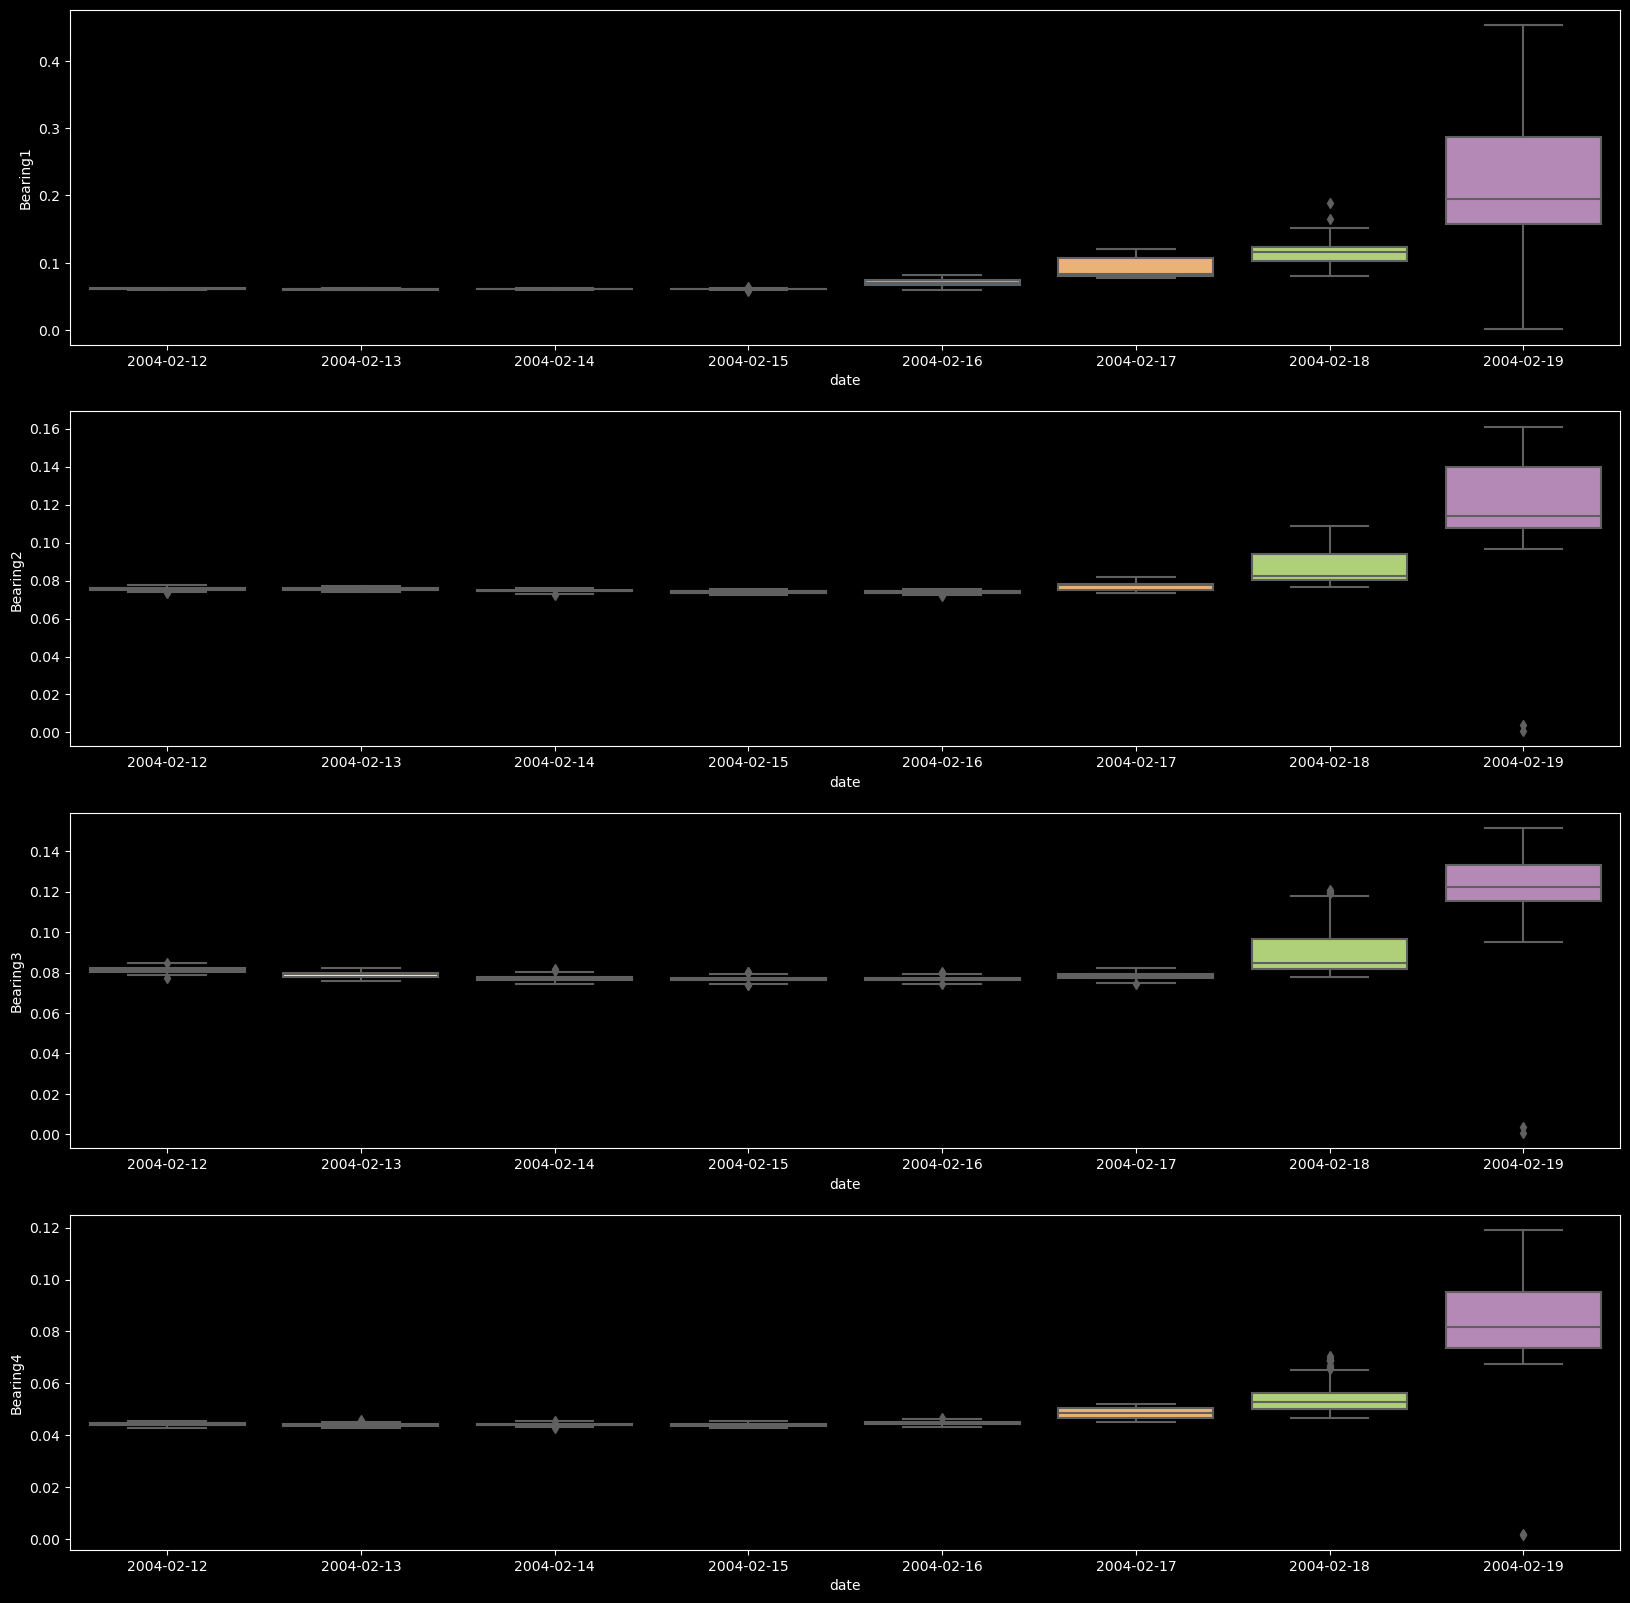

In [23]:
# Box plot 활용 day별 Bearing 분포 확인
col_n = 1
row_n = 4

fig, ax = plt.subplots(ncols=col_n, nrows=row_n, figsize=(20, row_n*5))

for i,col in enumerate(df.columns[0:4]):
    sns.boxplot(x='date', y=col, data=df, ax=ax[int(i%row_n)])

In [26]:
# sns.boxplot : 언제부터 퍼졌는지 확인할 수 있음
# 점이 있으면 Outlier 가 발생했다는 것

# 16일부터 전조 증상이 있다가 17일부터 이상이 발생했다는 인사이트를 얻어냄

## lag(지연) 데이터 생성

- 시계열 데이터는 시간종속적 일 가능성이 크다
- 시계열 데이터에서 이전에 값을 고려할 때 lag(지연) 데이터를 사용

In [27]:
df.head()

,Bearing1,Bearing2,Bearing3,Bearing4,year,month,weekday,hour,date
,,,,,,,,,
2004-02-12 10:52:39,0.060236,0.074227,0.083926,0.044443,2004,2,3,10,2004-02-12
2004-02-12 11:02:39,0.061455,0.073844,0.084457,0.045081,2004,2,3,11,2004-02-12
2004-02-12 11:12:39,0.061361,0.075609,0.082837,0.045118,2004,2,3,11,2004-02-12
2004-02-12 11:22:39,0.061665,0.073279,0.084879,0.044172,2004,2,3,11,2004-02-12
2004-02-12 11:32:39,0.061944,0.074593,0.082626,0.044659,2004,2,3,11,2004-02-12


In [30]:
# shift 명령어를 통해 lag 데이터를 생성 (파생 변수)
df['Bearing1_lag'] = df['Bearing1'].shift(1)        # Bearing1을 shift 시켜 Bearing1_lag 를 생성 (지연데이터)
df[['Bearing1', 'Bearing1_lag']]        # 이전 데이터와 함께 출력함으로써 빼거나 나눠서 변화량을 구할 수 있음

,Bearing1,Bearing1_lag
,,
2004-02-12 10:52:39,0.060236,NaN
2004-02-12 11:02:39,0.061455,0.060236
2004-02-12 11:12:39,0.061361,0.061455
2004-02-12 11:22:39,0.061665,0.061361
2004-02-12 11:32:39,0.061944,0.061665
...,...,...
2004-02-19 05:42:39,0.453335,0.301344
2004-02-19 05:52:39,0.337583,0.453335
2004-02-19 06:02:39,0.351111,0.337583


In [31]:
# lag 데이터의 처음 NaN값 처리 (0 또는 첫번째 값 대입)
# fill_value=
df['Bearing1_lag'] = df['Bearing1'].shift(1, fill_value=df['Bearing1'][0])
df[['Bearing1', 'Bearing1_lag']]

,Bearing1,Bearing1_lag
,,
2004-02-12 10:52:39,0.060236,0.060236
2004-02-12 11:02:39,0.061455,0.060236
2004-02-12 11:12:39,0.061361,0.061455
2004-02-12 11:22:39,0.061665,0.061361
2004-02-12 11:32:39,0.061944,0.061665
...,...,...
2004-02-19 05:42:39,0.453335,0.301344
2004-02-19 05:52:39,0.337583,0.453335
2004-02-19 06:02:39,0.351111,0.337583


## 이동 평균 (Rolling window)

- 이전 값들까지 더해 평균을 만듦

In [33]:
# rolling 을 사용해서 이동 평균 생성 (파생 변수)
df['bearing1_ma_3'] = df['Bearing1'].rolling(window=3).mean()        # 3개의 평균
df[['Bearing1', 'bearing1_ma_3']]

,Bearing1,bearing1_ma_3
,,
2004-02-12 10:52:39,0.060236,NaN
2004-02-12 11:02:39,0.061455,NaN
2004-02-12 11:12:39,0.061361,0.061018
2004-02-12 11:22:39,0.061665,0.061494
2004-02-12 11:32:39,0.061944,0.061656
...,...,...
2004-02-19 05:42:39,0.453335,0.364315
2004-02-19 05:52:39,0.337583,0.364087
2004-02-19 06:02:39,0.351111,0.380676


In [36]:
# NaN 값 처리 (자신값 대입)
df['bearing1_ma_3'].fillna(df['Bearing1'], inplace=True)
df[['Bearing1', 'bearing1_ma_3']]

,Bearing1,bearing1_ma_3
,,
2004-02-12 10:52:39,0.060236,0.060236
2004-02-12 11:02:39,0.061455,0.061455
2004-02-12 11:12:39,0.061361,0.061018
2004-02-12 11:22:39,0.061665,0.061494
2004-02-12 11:32:39,0.061944,0.061656
...,...,...
2004-02-19 05:42:39,0.453335,0.364315
2004-02-19 05:52:39,0.337583,0.364087
2004-02-19 06:02:39,0.351111,0.380676


# 5. 이상 탐지 모델링

## Model Selection

- PCA 이상 탐지
- 평균에서 멀어진 데이터를 식별하려고 함

In [37]:
# 여러 변수 간에 존재하는 상관관계를 이용하여 이를 대표한 주성분을 추출해 차원을 축소하는 기법
# 기존 데이터의 유실을 최소화 하기 위해 데이터의 분산을 최대화 할 수 있는 초평면 (Hyper plane)을 찾고 데이터를 투영함
# Auto encoder와 작동원리가 유사함
# 다중공선성을 제거하기 위해 각 벡터의 축이 직각이 되도록 투영 시킴
# 원본 데아터의 Feature 개수에 비해 매우 적은 주성분으로 원본 데이터의 총 변동성을 대부분 설명할 수 있는 분석법

장단점


[good] 고차원 데이터를 저차원에 주성분으로 표현할 수 있음

[good] 선택한 변수들의 해석이 용이함

[bad] 변수간 상관관계 고려가 어려움

[bad] 추출된 변수의 해석이 어려움 (주성분, PC1/PC2, ... )

## 차원축소 및 변수 설명력 확인

In [38]:
df.head()

,Bearing1,Bearing2,Bearing3,Bearing4,year,month,weekday,hour,date,Bearing1_lag,bearing1_ma_3
,,,,,,,,,,,
2004-02-12 10:52:39,0.060236,0.074227,0.083926,0.044443,2004,2,3,10,2004-02-12,0.060236,0.060236
2004-02-12 11:02:39,0.061455,0.073844,0.084457,0.045081,2004,2,3,11,2004-02-12,0.060236,0.061455
2004-02-12 11:12:39,0.061361,0.075609,0.082837,0.045118,2004,2,3,11,2004-02-12,0.061455,0.061018
2004-02-12 11:22:39,0.061665,0.073279,0.084879,0.044172,2004,2,3,11,2004-02-12,0.061361,0.061494
2004-02-12 11:32:39,0.061944,0.074593,0.082626,0.044659,2004,2,3,11,2004-02-12,0.061665,0.061656


In [39]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

# 베어링만 가져옴
df = df[['Bearing1', 'Bearing2', 'Bearing3', 'Bearing4']]

# 정규화 작업 scaler : 숫자 범주를 보정(표준화)
scaler = StandardScaler()

# pca 인스턴스
pca = PCA()

# 파이프라인 - 전처리 활동을 수행해줌
pipeline = make_pipeline(scaler, pca)
pipeline.fit(df)

Pipeline(steps=[('standardscaler', StandardScaler()), ('pca', PCA())])

In [41]:
# pca.n_components_ (차원 축소 주성분의 개수)
features = range(pca.n_components_)
feature_df = pd.DataFrame(data=features, columns=['pc_feature'])

# pca.explained_variance_ratio_ (설명력)
variance_df = pd.DataFrame(data = pca.explained_variance_ratio_, columns=['variance'])
pc_feature_df = pd.concat([feature_df, variance_df], axis=1)
pc_feature_df

# PC0, PC1 만으로도 전체 분산의 98% 이상 변동률 설명이 가능하기 때문에
# 주성분으로 PC0 와 PC1만 사용하고자 함 (다차원이 될 수록 해석이 어려워짐)

,pc_feature,variance
0,0,0.935243
1,1,0.052920
2,2,0.007789
3,3,0.004048


## 시각화 및 Threshold 선정

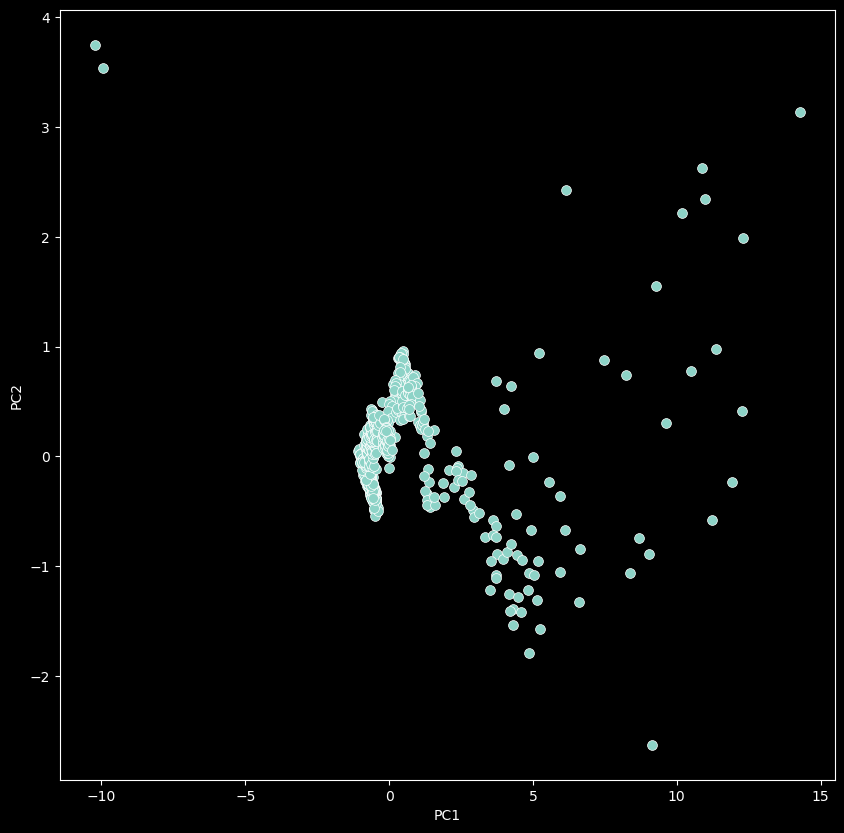

In [42]:
# 정규화
X_ = StandardScaler().fit_transform(df)

# 2개의 주성분으로 차원 축소
pca = PCA(n_components = 2)
pc = pca.fit_transform(X_)

pc_df = pd.DataFrame(pc, columns=['PC1', 'PC2']).reset_index(drop=True)

plt.rcParams['figure.figsize'] = [10, 10]
sns.scatterplot(data = pc_df, x='PC1', y='PC2', legend='brief', s=50, linewidth=0.5);

# 각 클러스터 중심에서 멀리 떨어진 Data 일 수록 이상치

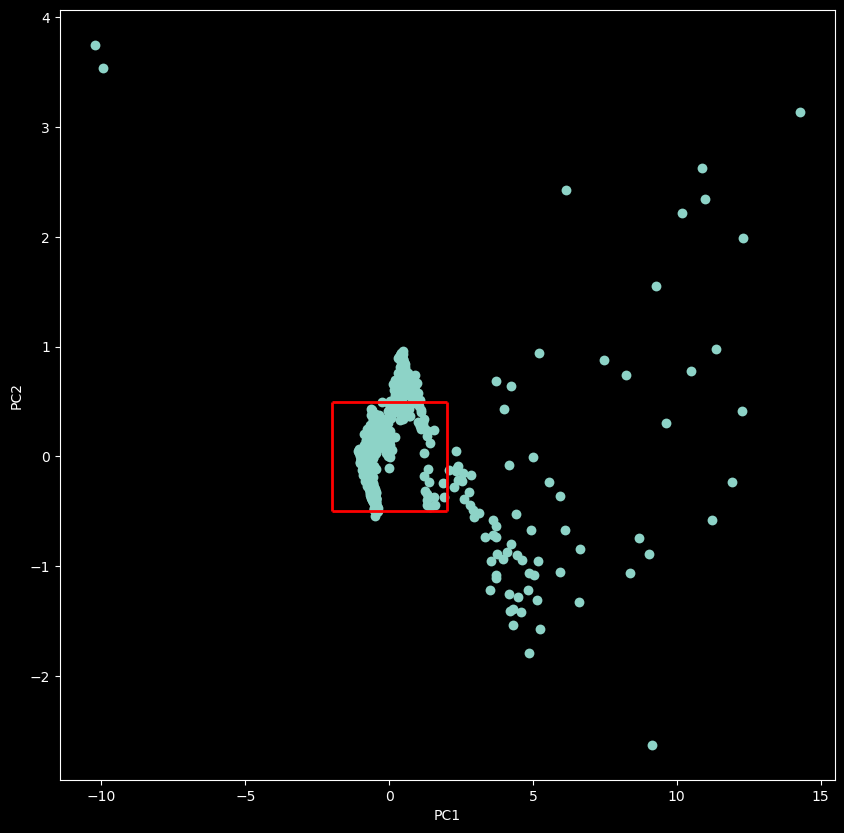

In [44]:
# PC1, PC2인 차원 축소 변수 2, -2 기준으로 등급 부여
sns.scatterplot(data = pc_df, x='PC1', y='PC2', s=50, linewidth=0);

# 정상치 범주 표현
plt.vlines(-2, ymin=-0.5, ymax=0.5, color='r', linewidth=2);
plt.vlines(2, ymin=-0.5, ymax=0.5, color='r', linewidth=2);

plt.hlines(-0.5, xmin=-2, xmax=2, color='r', linewidth=2);
plt.hlines(0.5, xmin=-2, xmax=2, color='r', linewidth=2);

plt.gcf().set_size_inches(10, 10)

## Abnormal Labeling (이상치 레이블링)

In [45]:
# np.where 활용 if문

# 이상치를 판단하는 컬럼 추가
pc_df['abnormal'] = np.where((pc_df['PC1']>-2) & (pc_df['PC1']<2) & (pc_df['PC2']>-1) & (pc_df['PC2']<1), 0, 1)
pc_df.head()

,PC1,PC2,abnormal
0,-0.509598,-0.478672,0
1,-0.454730,-0.465373,0
2,-0.446235,-0.416285,0
3,-0.507399,-0.490065,0
4,-0.516699,-0.381590,0


In [47]:
pc_df['abnormal'].value_counts()

0    903
1     79
Name: abnormal, dtype: int64

In [46]:
# 기존 Data의 index 부여
pc_df.index = df.index
pc_df.head()

,PC1,PC2,abnormal
,,,
2004-02-12 10:52:39,-0.509598,-0.478672,0
2004-02-12 11:02:39,-0.454730,-0.465373,0
2004-02-12 11:12:39,-0.446235,-0.416285,0
2004-02-12 11:22:39,-0.507399,-0.490065,0
2004-02-12 11:32:39,-0.516699,-0.381590,0


In [48]:
# 기존 데이터와 concat
df_concat = pd.concat([df, pc_df], axis=1)
df_concat.head()

,Bearing1,Bearing2,Bearing3,Bearing4,PC1,PC2,abnormal
,,,,,,,
2004-02-12 10:52:39,0.060236,0.074227,0.083926,0.044443,-0.509598,-0.478672,0
2004-02-12 11:02:39,0.061455,0.073844,0.084457,0.045081,-0.454730,-0.465373,0
2004-02-12 11:12:39,0.061361,0.075609,0.082837,0.045118,-0.446235,-0.416285,0
2004-02-12 11:22:39,0.061665,0.073279,0.084879,0.044172,-0.507399,-0.490065,0
2004-02-12 11:32:39,0.061944,0.074593,0.082626,0.044659,-0.516699,-0.381590,0


## 모델 평가

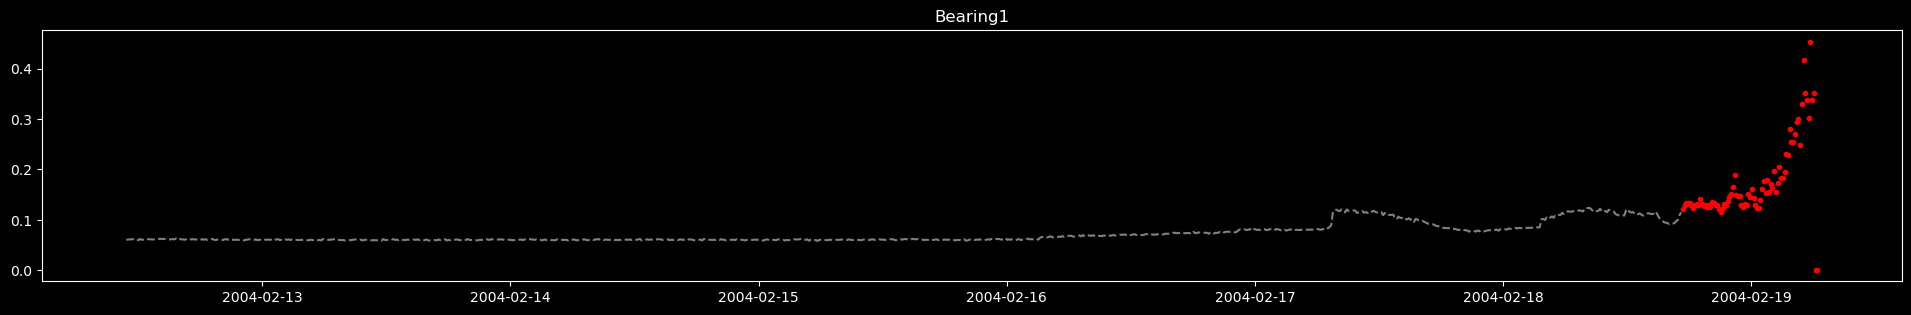

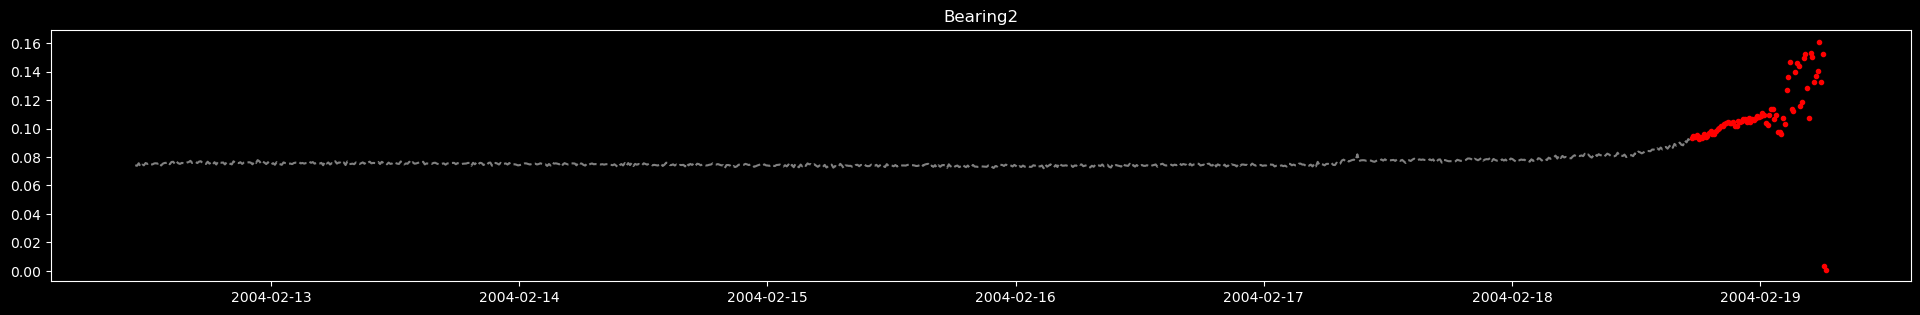

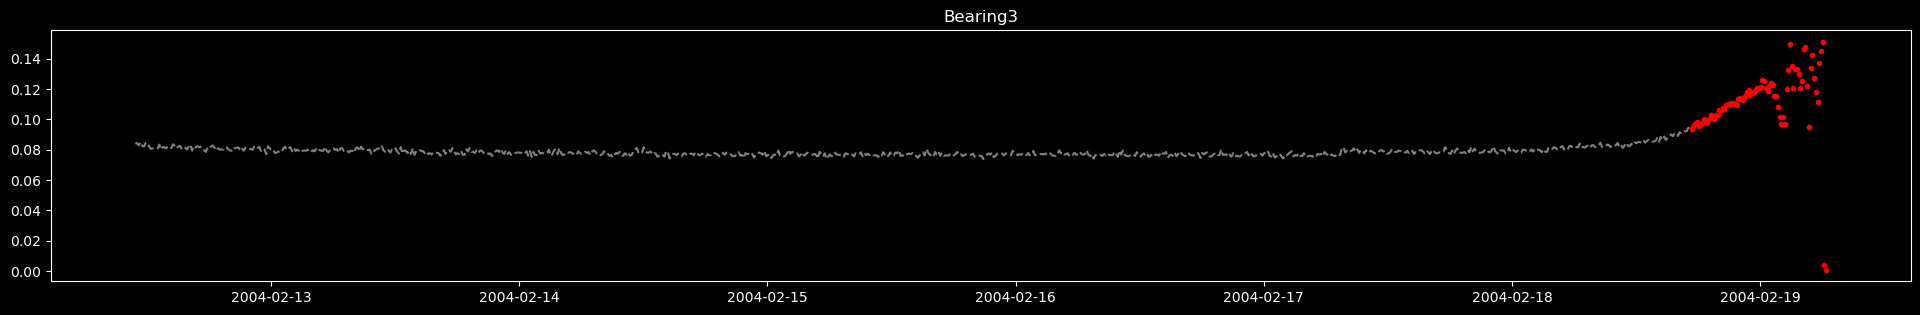

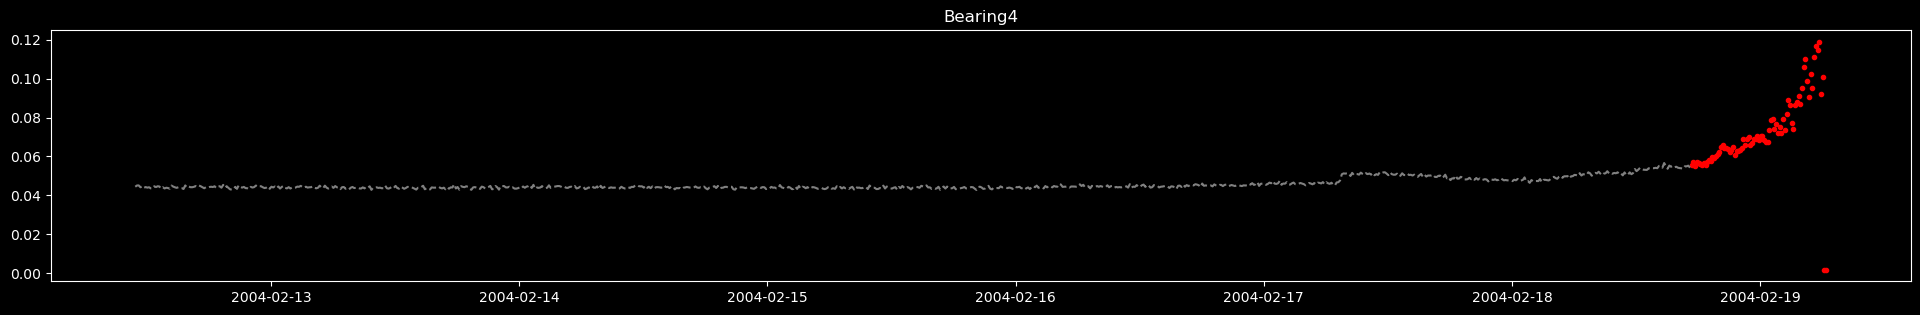

In [49]:
# Anomaly Points Plot

df_abnormal = df_concat[df_concat['abnormal'] == 1]
df_normal = df_concat[df_concat['abnormal'] == 0]

for v, i in enumerate(df.columns[0:4]):
    plt.figure(figsize=(24, 15))
    plt.subplot(4, 1, v+1)
    plt.plot(df_abnormal.index, df_abnormal[i], 'o', color='red', markersize=3);
    plt.plot(df_normal.index, df_normal[i], linestyle='--', color='grey');
    plt.title(i)

### 결과데이터가 만족스럽지 못하면 Threshold 를 조정한다

In [51]:
# Threshold 조정
pc_df['abnormal'] = np.where((pc_df['PC1']>-1) & (pc_df['PC1']<1) & (pc_df['PC2']>-1) & (pc_df['PC2']<1), 0, 1)

print(pc_df['abnormal'].value_counts())

# 재작업
pc_df.index = df.index
df_concat = pd.concat([df, pc_df], axis=1)


0    864
1    118
Name: abnormal, dtype: int64


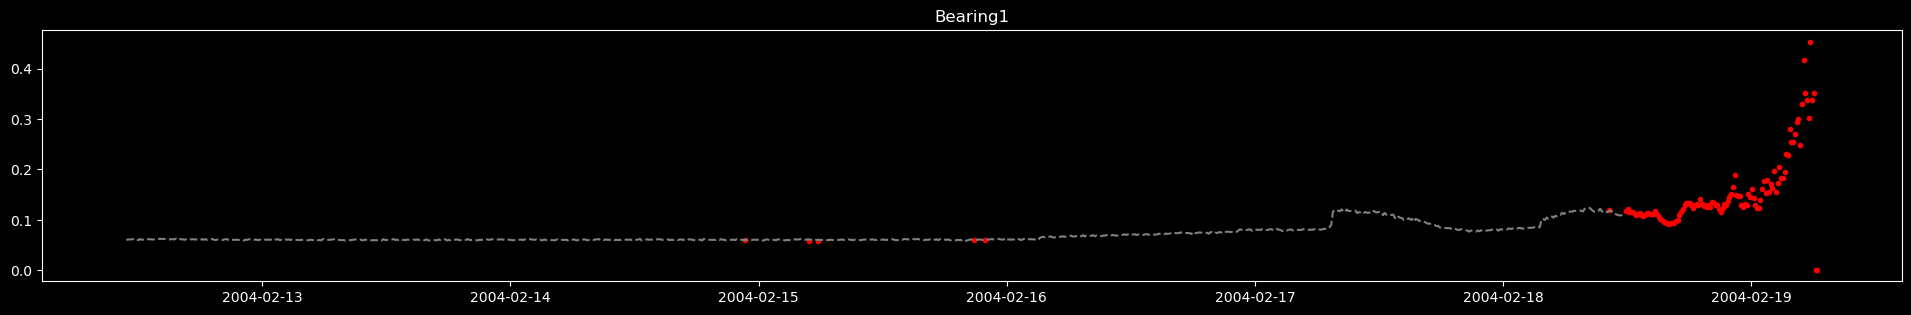

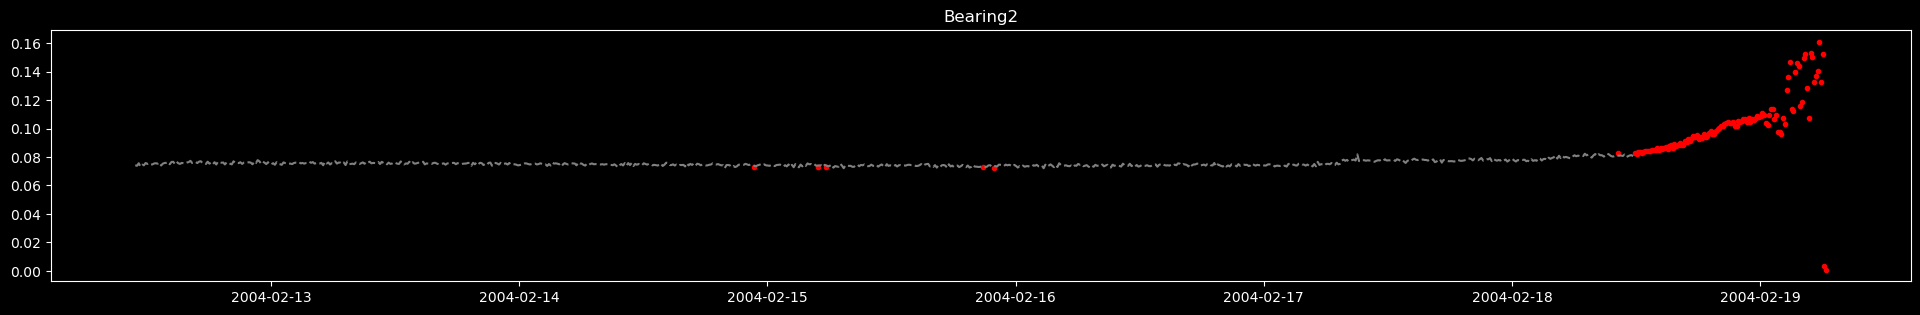

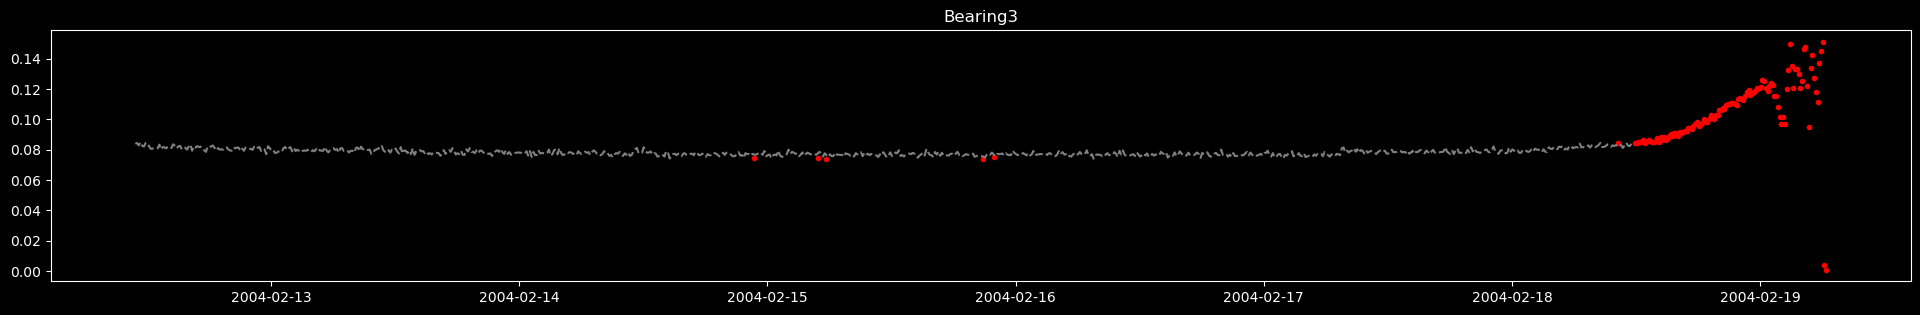

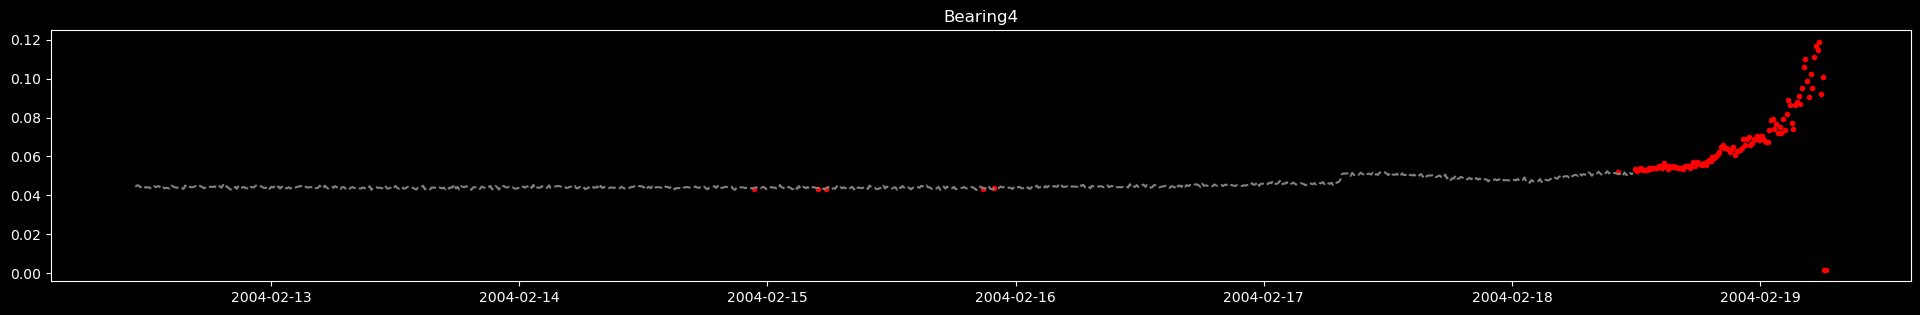

In [52]:
# Threshold 조정 후 재평가

df_abnormal = df_concat[df_concat['abnormal'] == 1]
df_normal = df_concat[df_concat['abnormal'] == 0]

for v, i in enumerate(df.columns[0:4]):
    plt.figure(figsize=(24, 15))
    plt.subplot(4, 1, v+1)
    plt.plot(df_abnormal.index, df_abnormal[i], 'o', color='red', markersize=3);
    plt.plot(df_normal.index, df_normal[i], linestyle='--', color='grey');
    plt.title(i)

In [54]:
# 아직까지도 17일과 18일을 이상치로 잡지 않으면서, false알람이 발생함
# Threshold 조정을 하면서 보정을 하고
# 충분치 않다면 다른 방법론을 찾아본다